# Reinforcement Learning Project: Control in a Continuous Action Space with DDPG

In this project, we will explore the Deep Deterministic Policy Gradient (DDPG) algorithm, which is designed to handle continuous action spaces in Reinforcement Learning. We will use the [Pendulum-v1](https://www.gymlibrary.dev/environments/classic_control/pendulum/) environment implemented in OpenAI Gym to implement the DDPG algorithm from scratch to solve the classical control problem of stabilizing an inverted pendulum. Throughout the development, we will incrementally build the components of DDPG and analyze their importance for correct and effective learning. 

This Jupyter notebook contains our implementation and report for this project. Do not forget to remove the report parts before submitting the notebook.

The instructions are available in `Miniproject_DDPG.pdf` file.

In [57]:
import numpy as np
from scipy import stats
import gym
from helpers import NormalizedEnv

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import copy

from tqdm import tqdm

from typing import Union


Global Instances

In [58]:
# Select device: 'cpu' or 'cuda'
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)

# Create environement instance, an instance of the Pendulum-v1 environment wrapped in a NormalizedEnv class
# to normalize the action space between -1 and 1
env = gym.make('Pendulum-v1', render_mode='rgb_array')
env = NormalizedEnv(env)

# Number of steps per episode, see documentation of the Pendulum-v1 environment
n_steps = 200

Using device: cpu


# Toolbox

In [59]:
def reset_random(seed: int = 42) -> None:
    """Reset numpy, pyTorch and env random seeds."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.reset(seed=seed)

## Networks

In [60]:
class QNetwork(nn.Module):
    def __init__(self, state_size: int=env.observation_space.shape[0], action_size: int=env.action_space.shape[0]):
        """QNetwork. Maps (state, action) pairs to Q-values."""
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """Forward pass of the network.

        Args:
            state (torch.Tensor): State tensor
            action (torch.Tensor): Action tensor

        Returns:
            q_value (torch.Tensor): Q-value tensor
        """
        x = torch.cat([state, action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class PolicyNetwork(nn.Module):
    def __init__(self, state_size: int=3, action_size: int=1):
        """PolicyNetwork. Maps states to actions."""
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, state):
        """Forward pass of the network.

        Args:
            state (torch.Tensor): State tensor

        Returns:
            action (torch.Tensor): Action tensor
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

## Action Noises

In [61]:
class ActionNoise:
    def __init__(self):
        raise NotImplementedError
    
    def get_noisy_action(self, action: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError
    
class GaussianActionNoise(ActionNoise):
    def __init__(self, sigma: float=0.3):
        """Gaussian action noise."""
        assert(sigma>0), 'sigma must be positive'
        self.sigma = sigma

    def get_noisy_action(self, action: torch.Tensor) -> torch.Tensor:
        noise = torch.normal(mean=0, std=self.sigma, size=action.shape)
        return torch.clamp(action + noise, -1, +1)
    
class OUActionNoise(ActionNoise):
    def __init__(self, theta: float=0.15, sigma: float=0.3):
        """Ornstein-Uhlenbeck action noise."""
        assert(theta>=0 and theta<=1), 'theta must be between 0 and 1 (included)'
        assert(sigma>=0), 'sigma must be non-negative'
        self.theta = theta
        self.sigma = sigma
        self.noise = torch.zeros(env.action_space.shape[0])
        
    def get_noisy_action(self, action: torch.Tensor) -> torch.Tensor:
        self.noise = (1-self.theta)*self.noise + torch.normal(0, self.sigma, size=self.noise.shape)
        return torch.clamp(action + self.noise, -1, +1)

## Policies

In [62]:
# TODO docstring
class Agent:
    def __init__(self, env: NormalizedEnv=env) -> None:
        """Abstract agent class."""
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        
    def compute_action(self, state: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    
class RandomAgent(Agent):
    def __init__(self, env: NormalizedEnv=env) -> None:
        """Random agent.
        
        The random agent uniformly samples actions from the action space.
        """
        super().__init__(env)
        
    def compute_action(self, state: np.ndarray) -> np.ndarray:
        """Choose an uniformly random action from the action space."""
        size = state.shape[:-1] + (self.action_size,)
        return np.random.uniform(-1, 1, size=size)
    
class HeuristicPendulumAgent(Agent):
    def __init__(self, torque_intensity: float=1.0, env: NormalizedEnv=env) -> None:
        """Heuristic pendulum agent.
        
        The heuristic pendulum agent accelerates the pendulum in the lower half of the domain and decelerates it in the upper half of the domain.
        """
        super().__init__(env)
        self.torque_intensity = torque_intensity
        
    def compute_action(self, state: np.ndarray) -> np.ndarray:
        """Compute the action to apply to the environment.

        When the pendulum is in the lower half of the domain, applies a fixed torque in the same direction as the pendulum's angular velocity.
        When the pendulum is in the upper half of the domain, applies a fixed torque in the opposite direction as the pendulum's angular velocity.
        """
        action = np.where(state[..., [0]] < 0, # If the pendulum is in the lower half of the circle
                        np.sign(state[..., [2]]) * self.torque_intensity, 
                        -np.sign(state[..., [2]]) * self.torque_intensity)
        return action
    
class DDPGAgent(Agent):
    def __init__(self, action_noise: ActionNoise=GaussianActionNoise(), env: NormalizedEnv=env) -> None:
        """DDPG agent.
        
        The DDPG agent uses a policy network to compute actions.
        Actions can be noisy or not.
        """
        super().__init__(env)
        self.policy_network = PolicyNetwork(self.state_size, self.action_size).to(device)
        self.noise = action_noise
        
    def compute_action(self, state: np.ndarray, deterministic: bool=True) -> torch.Tensor:
        """
        Compute the action to apply to the environment.

        !!! Return a tensor, not a numpy array
        """
        state_t = torch.from_numpy(state).to(device)
        action = self.policy_network(state_t)
        if not deterministic:
            action = self.noise.get_noisy_action(action)
        return action
    
class DDPGAgentWithTargetNetwork(DDPGAgent):
    def __init__(self, action_noise: ActionNoise=GaussianActionNoise(), env: NormalizedEnv=env) -> None:
        """DDPG agent with target network.
        
        The DDPG agent uses a policy network to compute actions.
        The actions can be generated by the policy network or by the target policy network.
        The actions can be noisy or not.
        """
        super().__init__(action_noise, env)
        # Initialize target network with the same weights as the policy network
        self.target_policy_network = PolicyNetwork(self.state_size, self.action_size).to(device)
        self.target_policy_network.load_state_dict(self.target_policy_network.state_dict())

    def compute_action(self, state: np.ndarray, target: bool=False, deterministic: bool=True) -> torch.Tensor:
        """
        Compute the action to apply to the environment.

        !!! Return a tensor, not a numpy array
        """
        state_t = torch.from_numpy(state).to(device)
        if target:
            action = self.target_policy_network(state_t)
        else:
            action = self.policy_network(state_t)
        if not deterministic:
            action = self.noise.get_noisy_action(action)
        return action


## Replay Buffer

In [63]:
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        """Buffer to store transitions.

        A transition is a tuple (state, action, reward, next_state, trunc) where:
            state (np.ndarray[(3,), np.float32]): State of the environment.
            action (np.ndarray[(1,), np.float32]): Action applied to the environment.
            reward (np.ndarray[(1,), np.float32]): Reward obtained after applying the action.
            next_state (np.ndarray[(3,), np.float32]): State of the environment after applying the action.
            trunc (np.ndarray[(1,), np.bool]): Boolean indicating if the episode is truncated.
        
        The buffer is implemented as 5 (one for each element of a transition) cyclic numpy arrays of shape 
        (capacity, *) where * is the shape of the corresponding element of a transition.
        When the buffer is full, the oldest transitions are dropped.
        
        Args:
            capacity (int): Capacity of the buffer.
        """
        self.capacity = capacity 
        self.states = np.empty((capacity, 3), np.float32)
        self.actions = np.empty((capacity, 1), np.float32)
        self.rewards = np.empty((capacity, 1), np.float32)
        self.next_states = np.empty((capacity, 3), np.float32)
        self.truncs = np.empty((capacity, 1), bool)
        # Index of the next transition to be stored
        self.index = 0
        # Current size of the buffer
        self.size = 0

    def append(self, transition):
        """Add a transition to the buffer.
        
        See constructor docstring for explanation of a transition.
        """
        # Add transition to current index
        self.states[self.index] = transition[0]
        self.actions[self.index] = transition[1]
        self.rewards[self.index] = transition[2]
        self.next_states[self.index] = transition[3]
        self.truncs[self.index] = transition[4]
        # Update index
        self.index = (self.index + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int):
        """Sample a batch of size `batch_size` of transitions from the buffers."""
        indexes = np.random.choice(self.size, batch_size, replace=False)
        return self[indexes]

    def __len__(self) -> int:
        return self.size
    
    def __getitem__(self, slice):
        return (self.states[slice], 
                self.actions[slice], 
                self.rewards[slice], 
                self.next_states[slice], 
                self.truncs[slice])


## Training

In [64]:
def TD_learning_update(q_network: QNetwork, 
                       agent: Agent, 
                       optimizer: torch.optim.Optimizer, 
                       transitions: tuple, 
                       gamma: float,
                       target_q_network: QNetwork=None
                       ) -> float:
    """Perform a 1-step TD-learning update for a batch of transitions."""
    if isinstance(agent, DDPGAgentWithTargetNetwork) and target_q_network is None:
        raise ValueError("target_q_network must be provided when agent is a DDPGAgentWithTargetNetwork agent")
    
    states = transitions[0]
    actions = transitions[1]
    rewards = transitions[2]
    next_states = transitions[3]
    truncs = transitions[4]

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states).to(device)
    actions_t = torch.from_numpy(actions).to(device)
    rewards_t = torch.from_numpy(rewards).to(device)
    next_states_t = torch.from_numpy(next_states).to(device)
    truncs_t = torch.from_numpy(truncs).to(device)

    with torch.no_grad():
        if isinstance(agent, DDPGAgent):
            deterministic = True
            if isinstance(agent, DDPGAgentWithTargetNetwork): # We use target network for target Q-values
                next_actions_t = agent.compute_action(next_states, target=True, deterministic=deterministic)
            else:
                next_actions_t = agent.compute_action(next_states, deterministic=deterministic)
        else:
            next_actions = agent.compute_action(next_states)
            next_actions_t = torch.as_tensor(next_actions).to(device, dtype=torch.float32)
        # Naive next Q-values (i.e. without taking truncation into account)
        if isinstance(agent, DDPGAgentWithTargetNetwork): # We use target network for target Q-values
            naive_next_qs = target_q_network(next_states_t, next_actions_t)
        else:
            naive_next_qs = q_network(next_states_t, next_actions_t)
        # Actual next Q-values (i.e. taking truncation into account)
        next_qs = torch.where(truncs_t, 
                              torch.zeros_like(rewards_t), 
                              naive_next_qs)
        gamma = torch.tensor(gamma, dtype=torch.float32)
        targets = rewards_t + gamma * next_qs

    loss = F.mse_loss(q_network(states_t, actions_t), targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def policy_learning_update(q_network: QNetwork, 
                           agent: DDPGAgent, 
                           optimizer: torch.optim.Optimizer, 
                           transitions: tuple) -> float:
    """Perform a policy learning update for a batch of transitions."""
    states = transitions[0]
    # States and actions torch tensors
    states_t = torch.from_numpy(states).to(device)
    if isinstance(agent, DDPGAgentWithTargetNetwork):
        actions_t = agent.compute_action(states, target=False, deterministic=True)
    else:
        actions_t = agent.compute_action(states, deterministic=True)

    # Q-values
    qs = q_network(states_t, actions_t)

    loss = -qs.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

# network is a QNetwork or a PolicyNetwork
def target_network_update(network: QNetwork | PolicyNetwork, 
                          target_network: QNetwork | PolicyNetwork, 
                          tau: float) -> None:
    """Update the target network using the following rule:
    
    theta_target = tau * theta + (1 - tau) * theta_target
    """
    if type(network) != type(target_network):
        raise ValueError("network and target_network must be of the same type")
    for target_param, param in zip(target_network.parameters(), network.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

def train(agent: Agent,
          q_network: QNetwork, 
          q_optimizer: torch.optim.Optimizer,
          policy_optimizer: torch.optim.Optimizer=None,
          target_q_network: QNetwork=None,
          tau: float=0.01,
          n_episodes: int=1000, 
          batch_size: int=128, 
          gamma: float=0.99, 
          buffer_capacity: int=10000, 
          env: NormalizedEnv=env,
          n_steps: int=n_steps, 
          verbose: bool=True) -> np.ndarray:
    """Train all the neural networks.

    If `agent` is a DDPGAgent, then `policy_optimizer` must be provided and will be used to train the policy.
    Otherwise, `policy_optimizer` is ignored and only the Q-network is trained.

    Args:
        agent: Agent to train
        q_network: Q-network
        q_optimizer: Optimizer for the Q-network
        policy_optimizer: Optimizer for the policy. Used only if `agent` is a DDPGAgent. 
        target_q_network: Target Q-network. Used only if `agent` is a DDPGAgentWithTargetNetwork.
        tau: Tau parameter for the target networks update. Used only if `agent` is a DDPGAgentWithTargetNetwork.
        n_episodes: Number of episodes to train for. 
        batch_size: Batch size for training. 
        gamma: Discount factor. 
        buffer_capacity: Capacity of the replay buffer. 
        env: Environment. 
        n_steps: Number of steps per episode. 
        verbose: Whether to print training logs. 
    
    Returns:
        If `agent` is not a DDPGAgent, returns the losses for the Q-network and the return of each episode.
        If `agent` is a DDPGAgent, returns the losses for the Q-network and the policy and the return of each episode.
    """
    if isinstance(agent, DDPGAgent) and policy_optimizer is None:
        raise ValueError("Policy optimizer must be provided for DDPGAgent agent.")
    if isinstance(agent, DDPGAgentWithTargetNetwork) and target_q_network is None:
        raise ValueError("Target Q-network must be provided for DDPGAgenWithTargetNetwork agent.")
    
    replay_buffer = ReplayBuffer(capacity=buffer_capacity) # Buffer of transitions
    q_losses = np.empty((n_episodes, n_steps)) # Losses for Q-network
    if isinstance(agent, DDPGAgent):
        policy_losses = np.empty((n_episodes, n_steps)) # Losses for policy network
    returns = np.empty(n_episodes) # Return (cumulative reward) for each episode

    progress_bar = tqdm(range(n_episodes), desc="Training", disable=not verbose, unit="episode")
    with progress_bar as episodes:
        for episode in episodes:
            state, _ = env.reset()
            step = 0
            cumulative_reward = 0
            while True:
                # Simulation step
                if isinstance(agent, DDPGAgent):
                    # Need this condition to set deterministic parameter.
                    # Not deterministic because we want to explore
                    deterministic = False
                    if isinstance(agent, DDPGAgentWithTargetNetwork):
                        # We explicitely set target to False because target network is used only when we update Q-network
                        action = agent.compute_action(state, target=False, deterministic=deterministic).detach().cpu().numpy()
                    else:
                        action = agent.compute_action(state, deterministic=deterministic).detach().cpu().numpy()
                else:
                    action = agent.compute_action(state)
                next_state, reward, _, trunc, _ = env.step(action)
                cumulative_reward += reward
                transition = (state, action, reward, next_state, trunc)
                replay_buffer.append(transition)
                # Training step
                if len(replay_buffer) >= batch_size:
                    transitions = replay_buffer.sample(batch_size)
                    # Train the Q-network
                    if isinstance(agent, DDPGAgentWithTargetNetwork):
                        # We use target network to compute the target Q-values
                        q_loss = TD_learning_update(q_network, agent, q_optimizer, transitions, gamma, target_q_network)
                    else:
                        q_loss = TD_learning_update(q_network, agent, q_optimizer, transitions, gamma)
                    # If we have a nan q-loss, we stop the training and raise an error
                    if np.isnan(q_loss):
                        raise ValueError("Loss Q is NaN.")
                    q_losses[episode, step] = q_loss
                    # Train the policy
                    if isinstance(agent, DDPGAgent):
                        # Needed only when the agent is a network
                        policy_loss = policy_learning_update(q_network, agent, policy_optimizer, transitions)
                        policy_losses[episode, step] = policy_loss
                    # Update the target networks
                    if isinstance(agent, DDPGAgentWithTargetNetwork):
                        # Needed only when we use target network
                        target_network_update(q_network, target_q_network, tau=tau)
                        target_network_update(agent.policy_network, agent.target_policy_network, tau=tau)

                else:
                    q_losses[episode, step] = np.nan
                    if isinstance(agent, DDPGAgent):
                        # Needed only when the agent is a network
                        policy_losses[episode, step] = np.nan

                if trunc:
                    break
                state = next_state
                step += 1   
            returns[episode] = cumulative_reward
            # Update the progress bar
            episodes.set_postfix_str(
                f"Q-loss: {round(np.nanmean(q_losses[episode]), 2)}"
                + (f", Policy-loss: {round(np.nanmean(policy_losses[episode]), 2)}" 
                   if isinstance(agent, DDPGAgent) else ""))
    if isinstance(agent, DDPGAgent):
        return q_losses, policy_losses, returns
    else:
        return q_losses, returns
    

## Assessment

In [201]:
def compute_return_mean_std(agent: Agent, n_episodes: int = 10, env: NormalizedEnv = env) -> float:
    """Run the agent for `num_episodes` episodes and return the average return and its standard deviation."""
    returns = np.empty(n_episodes)
    for episode in range(n_episodes):
        state, _ = env.reset()
        cumulative_reward = 0
        while True:
            # Simulation step
            if isinstance(agent, DDPGAgent):
                action = agent.compute_action(state, deterministic=True).detach().cpu().numpy()
            else:
                action = agent.compute_action(state)
            state, reward, _, trunc, _ = env.step(action)
            cumulative_reward += reward
            if trunc:
                break
        returns[episode] = cumulative_reward
    return np.mean(returns), np.std(returns)

def save_animation(filename: str, agent: Agent, env: NormalizedEnv = env) -> None:
    """Run the agent for one episode and save the frames as a gif in `Animations` folder."""
    state, _ = env.reset()
    frames = []
    while True:
        if not isinstance(agent, DDPGAgent):
            action = agent.compute_action(state)
        else:
            action = agent.compute_action(state, deterministic=True).detach().cpu().numpy()
        state, _, _, trunc, _ = env.step(action)
        frames.append(env.render())
        if trunc:
            break

    frames = np.array(frames)
    frames = [Image.fromarray(frame) for frame in frames]
    frames[0].save('Animations/' + filename + ".gif", 
                   save_all=True, 
                   append_images=frames[1:], 
                   duration=50, 
                   loop=0)

def heatmap(q_network: QNetwork, 
            torque:float, 
            velocity: float, 
            n_grid: int=100,
            show: bool=True, 
            suffix: str="",
            save: bool=False,
            name: str="unnamed_plot") -> tuple[plt.Figure, plt.Axes]:
    """
    Plot the heatmap of the Q-function for the given action and velocity.
    
    Args:
        q_network (QNetwork): Q-network
        torque (float): Torque
        velocity (float): Velocity
        show (bool, optional): Whether to show the plot. Defaults to True.
        suffix (str, optional): Suffix for the plot title. Defaults to "".
        
    Returns:
        fig (plt.Figure): Figure
        ax (plt.Axes): Axes
    """
    rad = np.linspace(0, 1, n_grid)
    azm = np.linspace(0, 2 * np.pi, n_grid)
    r, th = np.meshgrid(rad, azm)
    states = np.empty([n_grid, n_grid, 3])
    states[..., 0] = np.cos(th)
    states[..., 1] = np.sin(th)
    states[..., 2] = np.full((n_grid, n_grid), velocity)

    actions = np.full((n_grid, n_grid, 1), torque)

    z = q_network(torch.Tensor(states), torch.Tensor(actions)).detach().squeeze()

    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    ax.set_theta_zero_location("N")
    p = ax.pcolormesh(th, r, z)
    fig.colorbar(p, ax=ax)
    ax.set_title(f"Q-value for torque {torque} and velocity {velocity}" + suffix)
    ax.set_rticks([])
    ax.grid(False)

    if show:
        plt.show()

    if save:
        fig.savefig("Figures/" + name + ".png")
    
    return fig, ax


# Assignment

## 3 Heuristic policy

In [134]:
reset_random(42)
random_agent = RandomAgent(env)
n_episodes = 100
random_agent_mean_return, random_agent_std_return = compute_return_mean_std(random_agent, n_episodes, env)
print('Average return over {} episodes: {}±{}'.format(n_episodes, round(random_agent_mean_return), round(random_agent_std_return)))

Average return over 100 episodes: -1230±267


/tmp/ipykernel_935/4037917544.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


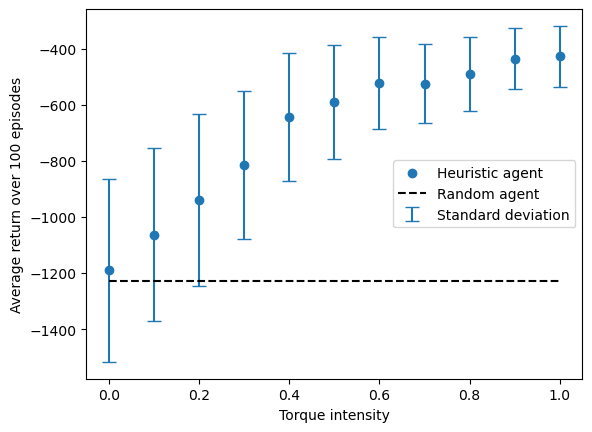

In [135]:
reset_random(42)
# Find best torque intensity
torque_intensities = np.linspace(0, 1, 11)
heuristic_agents = [HeuristicPendulumAgent(torque_intensity=torque_intensity, env=env) 
                    for torque_intensity in torque_intensities]
mean_returns = []
std_returns = []
for i, torque_intensity in enumerate(torque_intensities):
    heuristic_agent = heuristic_agents[i]
    return_mean, return_std = compute_return_mean_std(heuristic_agent, 100, env)
    mean_returns.append(return_mean)
    std_returns.append(return_std)

fig, ax = plt.subplots()
ax.scatter(torque_intensities, mean_returns, label='Heuristic agent')
ax.errorbar(torque_intensities, mean_returns, yerr=std_returns, fmt=' ', capsize=5, label='Standard deviation')
ax.hlines(y=random_agent_mean_return, xmin=0., xmax=1.0, linestyle = '--', color='black', label='Random agent')
ax.set_xlabel('Torque intensity')
ax.set_ylabel('Average return over 100 episodes')
ax.legend(loc='center right')
fig.show()
fig.savefig('Figures/3-Average-return.pdf')

# Best heuristic agent
best_heuristic_agent = heuristic_agents[np.argmax(mean_returns)]
best_torque_intensity = torque_intensities[np.argmax(mean_returns)]


In [214]:
# Save gif
save_animation("3-Best-heuristic-agent", best_heuristic_agent)

The environment consists of a pendulum attached to a fixed pivot point. Its position is described by the angle $\alpha$ between the pendulum and the upward vertical direction, and its (angular) velocity is $\dot{\alpha}$. The pendulum is actuated by applying a torque $\tau$ on its pivot point (the action space is thus continuous). The pendulum is subject to gravity, which is the only external force acting on it.

The pendulum starts in a random position, with a random velocity and the aim is to stabilize it in the inverted position, using little torque. More precisely, we want to maximise cummulative reward $-\left(\alpha^2 + 0.1\dot{\alpha}^2 + 0.001\tau^2\right)$ over a time horizon of 200 steps. The pendulum starts in a random position, with a random velocity.

First we will compare two policies: a random policy and a heuristic policy. 
The random policy is a policy that selects actions uniformly at random from the action space, i.e. it applies a tork of random magnitude (within the allowed range)in a random direction.
The heuristic policy is defined as follows:
- When the pendulum is in the lower half of the domain, applies a fixed torque in the same direction as the pendulum's angular velocity;
- When the pendulum is in the upper half of the domain, applies a fixed torque in the opposite direction as the pendulum's angular velocity.

The average return over 100 episodes and its standard deviation for the random policy is $-1230\pm 270$, which sets a baseline for the performance of the policies.

On Fig. 1, we see the average return over 100 episodes for the heuristic policy depending on the magnitude of the fixed torque. The performance increases linearly from $-1190\pm330$ for a null fixed torque to $-590\pm200$ for a fixed torque of $0.5$, and then increases with a smaller slope up to $-430\pm110$ for a fixed torque of $1$. The exact performance varies from one run to another, but when the performance increases the standard deviation decreases. We observe that the heuristic policy performs better than the random policy for all nonzero values of the fixed torque.


## 4 Q function of the heuristic policy

In [136]:
reset_random(42)
q_network = QNetwork().to(device)
q_network_before_training = copy.deepcopy(q_network)
optimizer = torch.optim.SGD(q_network.parameters(), lr=1e-4)
losses, _ = train(best_heuristic_agent, 
                  q_network, 
                  optimizer, 
                  n_episodes=1000, 
                  batch_size=128, 
                  gamma=0.99, 
                  buffer_capacity=10000, 
                  env=env, 
                  n_steps=n_steps, 
                  verbose=True)


Training: 100%|██████████| 1000/1000 [09:08<00:00,  1.82episode/s, Q-loss: 65.79]


/tmp/ipykernel_935/1575391299.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


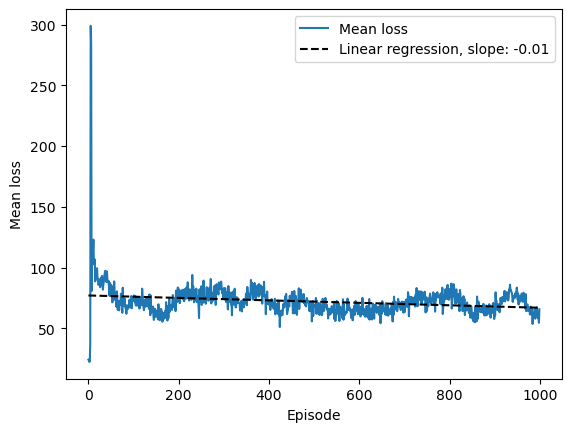

In [137]:
fig, ax = plt.subplots()
# Plot the mean loss per episode
ax.plot(np.nanmean(losses, axis=1), label='Mean loss')
# Add linear regression line
x = np.arange(losses.shape[0])
slope, intercept, _, _, _ = stats.linregress(x, np.nanmean(losses, axis=1))
ax.plot(x, slope*x + intercept, 'k--', label='Linear regression, slope: {:.2f}'.format(slope))

# Add legend and labels
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Mean loss')
fig.show()
fig.savefig('Figures/4-Mean-loss.pdf')

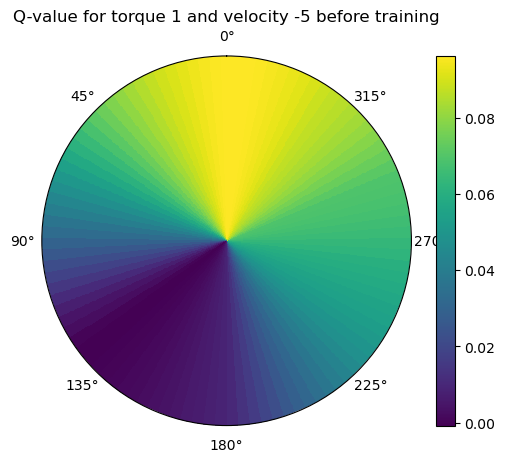

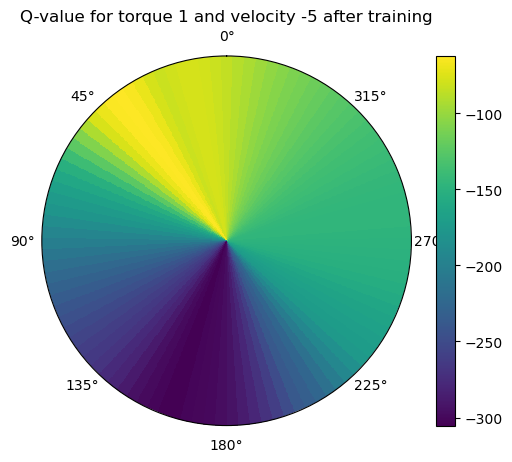

(<Figure size 640x480 with 2 Axes>,
 <PolarAxes: title={'center': 'Q-value for torque 1 and velocity -5 after training'}>)

In [213]:
torque = 1
velocity = -5
heatmap(q_network_before_training, torque, velocity, show=True, suffix=" before training", save=True, name="4-Heatmap-before-training_1_-5")
heatmap(q_network, torque, velocity, show=True, suffix=" after training", save=True, name="4-Heatmap-after-training_1_-5")

We now implement a critic, i.e. a Q-network, whose goal is to estimate the Q-function of the heuristic policy. We use a neural network with two hidden layers of 32 neurons each, with ReLU activation functions. It is updated using the semi-gradient of the mean squared error between the predicted and target Q-values. The training is done over 1000 epochs, with a batch size of 64.

On Fig. 2 we see the training curve with batches of size 128 and 1000 epochs. We can see that the training is very fast, with the loss decreasing to a value of approximately 70 after only 100 episodes. The loss then decreases more slowly, reaching a value close to 50 after 1000 episodes.



[TODO] comment the heatmaps

## 5 Minimal implementation of DDPG

In [80]:

reset_random(0)

q_network_DDPG = QNetwork().to(device)
action_noise = GaussianActionNoise(sigma=0.3)
ddpg_agent = DDPGAgent(action_noise=action_noise)
print(isinstance(ddpg_agent, DDPGAgent))
q_optimizer = torch.optim.SGD(q_network.parameters(), lr=1e-4)
policy_optimizer = torch.optim.SGD(ddpg_agent.policy_network.parameters(), lr=1e-4)

q_losses, policy_losses, returns = train(
    ddpg_agent, 
    q_network_DDPG, 
    q_optimizer, 
    policy_optimizer, 
    n_episodes=1000, 
    batch_size=128, 
    gamma=0.99, 
    buffer_capacity=10000)

torch.save(q_network.state_dict(), 'Networks/5-ddpg-agent.pt')


True


Training:   2%|▏         | 18/1000 [00:21<19:31,  1.19s/episode, Q-loss: 1043.07, Policy-loss: 467.37]


KeyboardInterrupt: 

In [150]:
#to delete
q_network_DDPG = QNetwork().to(device)
q_network_DDPG.load_state_dict(torch.load('/home/aude/workspace_vscode/ANN/DDPG-Inverted-Pendulum/Networks/5-q-network.pt'))

<All keys matched successfully>

/tmp/ipykernel_935/313364608.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


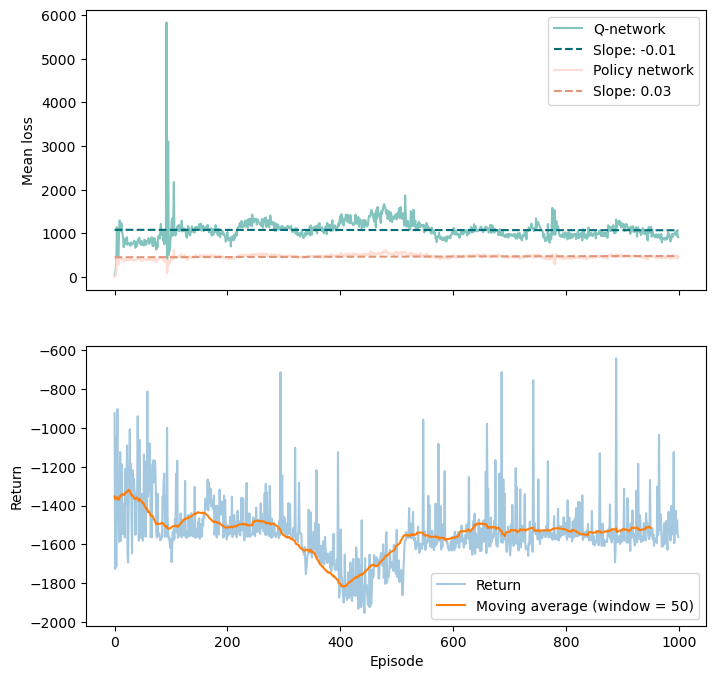

In [82]:
# Plot q and policy training curves and return on a subplot under
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

# Q training curve
ax1.plot(np.nanmean(q_losses, axis=1), label='Q-network', color='#83c5be')
# Add linear regression
x = np.arange(q_losses.shape[0])
slope_q, intercept_q, _, _, _ = stats.linregress(x, np.nanmean(q_losses, axis=1))
ax1.plot(x, slope_q*x + intercept_q, 
        label="Slope: {:.2f}".format(slope_q), color='#006d77', linestyle='--')
# Policy training curve
ax1.plot(np.nanmean(policy_losses, axis=1), label='Policy network', color='#ffddd2')
slope_policy, intercept_policy, _, _, _ = stats.linregress(x, np.nanmean(policy_losses, axis=1))
ax1.plot(x, slope_policy*x + intercept_policy, 
        label="Slope: {:.2f}".format(slope_policy), color='#e29578', linestyle='--')

ax1.set_ylabel('Mean loss')
ax1.legend()

# Moving average smoothing of the returns
ax2.plot(returns, alpha=0.4, label='Return')
window = 50
ax2.plot(np.convolve(returns, np.ones(window)/window, mode='valid'), 
        label='Moving average (window = {})'.format(window))
ax2.set_xlabel('Episode')
ax2.set_ylabel('Return')
ax2.legend()
fig.show()


In [83]:
# Test the agent
reset_random(42)
n_episodes = 100
ddpg_agent_mean_return, ddpg_agent_standard_deviation = compute_return_mean_std(ddpg_agent, n_episodes, env)
print('Average return over {} episodes: {}±{}'.format(n_episodes, round(ddpg_agent_mean_return), round(ddpg_agent_standard_deviation)))


Average return over 100 episodes: -1243±166


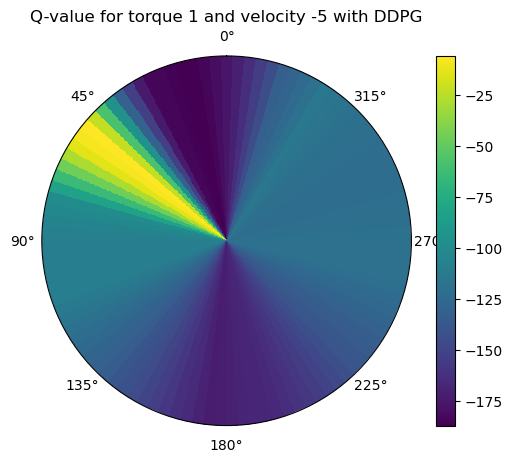

(<Figure size 640x480 with 2 Axes>,
 <PolarAxes: title={'center': 'Q-value for torque 1 and velocity -5 with DDPG'}>)

In [198]:
# Heatmaps of the Q-function
torque = 1
velocity = -5
heatmap(q_network_DDPG, torque, velocity, show=True, suffix=" with DDPG", save=True, name="5-Heatmap-DDPG_1_-5")

In [79]:
# Save gif
save_animation("5-DDPG-agent", ddpg_agent)

TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Tensor'

## 6. Target networks

In [ ]:
reset_random(42)
taus = np.logspace(-2, 0, 5)
tau_q_networks = []
tau_target_q_networks = []
tau_ddpg_agents_with_target_network = []
tau_q_losses = []
tau_policy_losses = []
tau_returns = []
for i, tau in enumerate(taus):
    # Train
    q_network = QNetwork().to(device)
    target_q_network = copy.deepcopy(q_network)
    action_noise = GaussianActionNoise(sigma=0.3)
    ddpg_agent_with_target_network = DDPGAgentWithTargetNetwork(action_noise=action_noise)
    q_optimizer = torch.optim.SGD(q_network.parameters(), lr=1e-4)
    policy_optimizer = torch.optim.SGD(ddpg_agent_with_target_network.policy_network.parameters(), lr=1e-4)

    q_losses, policy_losses, returns = train(
        ddpg_agent_with_target_network, 
        q_network, 
        q_optimizer, 
        policy_optimizer, 
        target_q_network, 
        tau=tau, 
        n_episodes=1000, 
        batch_size=128, 
        gamma=0.99, 
        buffer_capacity=10000)
    
    # Store results
    tau_q_networks.append(q_network)
    tau_target_q_networks.append(target_q_network)
    tau_ddpg_agents_with_target_network.append(ddpg_agent_with_target_network)
    tau_q_losses.append(q_losses)
    tau_policy_losses.append(policy_losses)
    tau_returns.append(returns)

In [ ]:
# Plot q and policy training curves and return on a subplot under
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 16))

for i, tau in enumerate(taus):
        # Q training curve
        ax1.plot(np.nanmean(tau_q_losses[i], axis=1), label='Q-network, tau={}'.format(round(tau, 2)))
        # Policy training curve
        ax2.plot(np.nanmean(tau_policy_losses[i], axis=1), label='Policy network, tau='.format(round(tau, 2)))

        # Moving average smoothing of the returns
        ax3.plot(tau_returns[i], alpha=0.4, label='Return, tau={}'.format(round(tau, 2)))
        window = 50
        ax3.plot(np.convolve(tau_returns[i], np.ones(window)/window, mode='valid'), 
                label='Moving average (window = {})'.format(window))

ax1.set_ylabel('Mean Q-loss')
ax1.legend()
ax2.set_ylabel('Mean policy loss')
ax2.legend()
ax3.set_xlabel('Episode')
ax3.set_ylabel('Return')
ax3.legend()
fig.show()


In [ ]:
# Test the agent
tau_ddpg_agent_with_target_network_mean_returns = [] 
tau_ddpg_agent_with_target_network_standard_deviations = []
for i, tau in enumerate(taus):
    n_episodes = 100
    mean_return, standard_deviation = compute_return_mean_std(tau_ddpg_agents_with_target_network[i], 100)
    tau_ddpg_agent_with_target_network_mean_returns.append(mean_return)
    tau_ddpg_agent_with_target_network_standard_deviations.append(standard_deviation)
    print('Average return over {} episodes, tau={}: {}±{}'.format(n_episodes, round(tau, 2), round(mean_return), round(standard_deviation)))

In [ ]:
# save gifs
for i, tau in enumerate(taus):
    save_animation("6-DDPG-agent-with-target-network-tau={}".format(round(tau, 2)), tau_ddpg_agents_with_target_network[i])

When experimenting with the first implementation of DDPG above, we noticed that depending on the choice of the seed, the training was unstable. This motivates the use of target networks, which are copies of the actor and critic networks that are "soft updated". This means that each step they are updated with a weighted average between the weights of the target network and the weights of the original network, i.e. each weight $w_{target}$ of the actor/critic target network are updated using this equation:
$$
w_\mathrm{target}^{(t+1)} = \tau\cdot w_\mathrm{original}^{(t)} + (1-\tau)\cdot w_\mathrm{target}^{(t)}
$$
with $\tau\in (0, 1)$. 

# 7 Ornstein-Uhlenbeck noise

In [ ]:
thetas = [0, 0.25, 0.5, 0.75, 1]
theta_agents = []
theta_q_losses = []
theta_policy_losses = []
theta_returns = []
for theta in thetas:
    q_network = QNetwork().to(device)
    target_q_network = copy.deepcopy(q_network)
    action_noise = OUActionNoise(theta=theta, sigma=0.3)
    ddpg_agent_with_target_network = DDPGAgentWithTargetNetwork(action_noise=action_noise)
    q_optimizer = torch.optim.SGD(q_network.parameters(), lr=1e-4)
    policy_optimizer = torch.optim.SGD(ddpg_agent.policy_network.parameters(), lr=1e-4)

    q_losses, policy_losses, returns = train(
        ddpg_agent_with_target_network, 
        q_network, 
        q_optimizer, 
        policy_optimizer, 
        target_q_network, 
        tau=0.2,
        n_episodes=1000, 
        batch_size=128, 
        gamma=0.99, 
        buffer_capacity=10000)
    
    theta_agents.append(ddpg_agent_with_target_network)
    theta_q_losses.append(q_losses)
    theta_policy_losses.append(policy_losses)
    theta_returns.append(returns)


In [ ]:
theta_mean_returns = []
for theta_agent in theta_agents:
    mean_return, _ = compute_return_mean_std(theta_agent, n_episodes=100)
    theta_mean_returns.append(mean_return)
    print(f'Mean return: {mean_return}')

Adding noise to the action helps exploration of the state space, which is necessary to learn a good policy. However, adding uncorrelated noise to subsequent actions is not very effective in practice, as it leads to trajectories close to the deterministic one. To improve the exploration of the algorithm, we replace the Gaussian noise with a (simplified) Ornstein-Uhlenbeck noise defined by the iterative equation:
$$
\mathrm{noise}^{(t+1)} = (1-\theta)\cdot \mathrm{noise}^{(t)} + \mathcal{N}(0, \sigma^2)
$$
with $\theta\in (0, 1)$.